In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

In [2]:
data = pd.read_csv('/kaggle/input/movielens-20m-dataset/rating.csv')
data = data.iloc[:10000]
movies_df = pd.read_csv("/kaggle/input/movielens-20m-dataset/movie.csv")
tags_df = pd.read_csv("/kaggle/input/movielens-20m-dataset/tag.csv")
genome_scores_raw = pd.read_csv("/kaggle/input/movielens-20m-dataset/genome_scores.csv")
# Filter genome_scores to only have movieIds present in the data dataframe
genome_scores = genome_scores_raw[genome_scores_raw['movieId'].isin(data['movieId'].unique())]

train_data = data.copy()
test_data = pd.DataFrame()
 
movie_num_user_rated_counts = train_data['movieId'].value_counts()
# Create a list of movie IDs with 50 or more ratings
popular_movies = movie_num_user_rated_counts[movie_num_user_rated_counts >= 10].index.tolist()
# Filter the DataFrame to keep only the rows with movies that meet the threshold
train_data = train_data[train_data['movieId'].isin(popular_movies)]

for user_id in train_data['userId'].unique():
    user_ratings = train_data[train_data['userId'] == user_id]
    
    if len(user_ratings) > 1:
        test_rating = user_ratings.sample()
        test_data = pd.concat([test_data, test_rating])
        train_data.drop(test_rating.index, inplace=True)

In [3]:
# import pandas as pd

# # Load the data
# data = pd.read_csv('/kaggle/input/movielens-20m-dataset/rating.csv')
# movies_df = pd.read_csv("/kaggle/input/movielens-20m-dataset/movie.csv")
# tags_df = pd.read_csv("/kaggle/input/movielens-20m-dataset/tag.csv")

# # Convert the timestamp column to datetime format for sorting
# data['timestamp'] = pd.to_datetime(data['timestamp'])

# # Filter users who have watched at least 30 movies
# user_counts = data['userId'].value_counts()
# eligible_users = user_counts[user_counts >= 30].index.tolist()

# # Initialize train and test dataframes
# train_data = pd.DataFrame()
# test_data = pd.DataFrame()

# # Iterate over eligible users and split their data
# for user_id in eligible_users:
#     user_data = data[data['userId'] == user_id].sort_values(by='timestamp', ascending=False)
    
#     # Add the latest 3 movies to the test set
#     test_data = pd.concat([test_data, user_data.iloc[:3]])
    
#     # Add the remaining movies to the train set
#     train_data = pd.concat([train_data, user_data.iloc[3:]])
    
#     # Check if train_data has reached the desired size
#     if 10000 <= len(train_data) <= 50000:
#         break

# # Filter the train_data to keep only popular movies
# movie_num_user_rated_counts = train_data['movieId'].value_counts()
# popular_movies = movie_num_user_rated_counts[movie_num_user_rated_counts >= 5].index.tolist()
# train_data = train_data[train_data['movieId'].isin(popular_movies)]


In [4]:
print(train_data)

      userId  movieId  rating            timestamp
2          1       32     3.5  2005-04-02 23:33:39
3          1       47     3.5  2005-04-02 23:32:07
4          1       50     3.5  2005-04-02 23:29:40
6          1      151     4.0  2004-09-10 03:08:54
7          1      223     4.0  2005-04-02 23:46:13
...      ...      ...     ...                  ...
9989      91     2716     3.5  2005-03-28 23:17:18
9990      91     2762     4.0  2005-03-22 22:48:33
9994      91     2791     3.0  2005-07-18 08:13:22
9995      91     2797     3.5  2005-03-29 01:53:41
9997      91     2858     4.5  2005-03-23 05:57:57

[3557 rows x 4 columns]


In [5]:
ratings_df = train_data
# Create a new graph
G = nx.Graph()

# 2. Adding nodes and edges
# Add user nodes
for user_id in ratings_df['userId'].unique():
    G.add_node('u_'+str(user_id), bipartite=0)  # Add user node with a bipartite attribute of 0

# Add movie nodes with title and genres as attributes
for _, row in movies_df.iterrows():
    movie_id = 'm_' + str(row['movieId'])
    G.add_node(movie_id, bipartite=1, title=row['title'], genres=row['genres'].split('|'))

# Add edges based on ratings with rating and timestamp as attributes
for _, row in ratings_df.iterrows():
    user_id = 'u_'+str(row['userId'])
    movie_id = 'm_' + str(row['movieId'])
    G.add_edge(user_id, movie_id, rating=row['rating'], timestamp=row['timestamp'])

# Add tag data as an attribute to the movie nodes
for _, row in tags_df.iterrows():
    movie_id = 'm_' + str(row['movieId'])
    if 'tags' not in G.nodes[movie_id]:
        G.nodes[movie_id]['tags'] = []
    G.nodes[movie_id]['tags'].append({'tag': row['tag'], 'timestamp': row['timestamp'], 'userId': row['userId']})

# Ensure the graph is bipartite
assert bipartite.is_bipartite(G)

In [6]:
def predict_rating(G, user, movie):
    neighbors = list(G.neighbors(movie))
    if not neighbors:
        return np.mean([attr['rating'] for _, _, attr in G.edges(data=True) if 'rating' in attr])

    sim_weights = []
    user_ratings = []
    for neighbor in neighbors:
        # Jaccard similarity as an example, but can be changed
        common_movies = list(nx.common_neighbors(G, user, neighbor))
        sim = len(common_movies) / (G.degree(user) + G.degree(neighbor) - len(common_movies))
        rating = G[neighbor][movie]['rating']
        
        sim_weights.append(sim)
        user_ratings.append(rating)
    
    return np.dot(user_ratings, sim_weights) / sum(sim_weights)


In [7]:
def random_walk_legacy(G, start_node, alpha=0.85, walk_length=10):
    """Perform a random walk on graph G starting from node start_node."""
    current_node = start_node
    path = [current_node]
    
    for _ in range(walk_length):
        neighbors = list(G.neighbors(current_node))
        if random.random() < alpha and neighbors:
            current_node = random.choice(neighbors)
        else:
            current_node = start_node
        path.append(current_node)
    
    return path
def weighted_choice(neighbors, weights):
    """Choose a neighbor based on the given weights."""
    total = sum(weights)
    r = random.uniform(0, total)
    upto = 0
    for n, w in zip(neighbors, weights):
        if upto + w >= r:
            return n
        upto += w

def random_walk(G, start_node, alpha=0.85, walk_length=10):
    """Perform a random walk on graph G starting from node start_node."""
    current_node = start_node
    path = [current_node]
    
    for _ in range(walk_length):
        neighbors = list(G.neighbors(current_node))
        
        if neighbors:
            # Get weights (ratings) of the edges to the neighbors
            weights = [G[current_node][neighbor].get('rating', 1) for neighbor in neighbors]
            
            if random.random() < alpha:
                current_node = weighted_choice(neighbors, weights)
            else:
                current_node = start_node
        else:
            current_node = start_node
            
        path.append(current_node)
    
    return path
def personalized_pagerank_recommendations(G, user, alpha=0.85, num_walks=50, walk_length=5):
    """Generate recommendations and explanations using Personalized PageRank via random walks."""
    # Perform random walks and keep track of visit counts
    visit_counts = {node: 0 for node in G.nodes()}
    all_paths = []
    user = 'u_'+str(user)
    
    for _ in range(num_walks):
        path = random_walk(G, user, alpha, walk_length)
        all_paths.append(path)
        for node in path:
            visit_counts[node] += 1
    
    # Normalize visit counts to get a probability distribution
    total_visits = sum(visit_counts.values())
    ppr = {node: count/total_visits for node, count in visit_counts.items()}
    
    # Filter for movies and sort by PPR score
    movies = [node for node in ppr.keys() if G.nodes[node]['bipartite'] == 1 and node not in G.neighbors(str(user))]
    sorted_movies = sorted(movies, key=lambda x: ppr[x], reverse=True)
    
    # Generate explanations for the top 10 movies
    explanations = {}
    significant_neighbors = {}
    contributing_paths_all = {}
    for movie in sorted_movies[:10]:
        # Find paths that contributed to the movie's score
        contributing_paths = [path for path in all_paths if movie in path]
        
        # Count the frequency of each neighbor leading to the movie
        neighbor_counts = {}
        for path in contributing_paths:
            for i in range(len(path) - 1):
                if path[i+1] == movie:
                    neighbor = path[1]
                    neighbor_counts[neighbor] = neighbor_counts.get(neighbor, 0) + 1

        # Identify the most significant neighbor
        sorted_neighbors = sorted(neighbor_counts, key=neighbor_counts.get, reverse=True)
        most_significant_neighbor = next((n for n in sorted_neighbors if not n.startswith('u_') and not n == movie), None)
        if most_significant_neighbor:
            significant_neighbors[movie] = most_significant_neighbor
        contributing_paths_all[movie] = contributing_paths


        
    
    return sorted_movies, contributing_paths_all, significant_neighbors


In [8]:
user = train_data['userId'].sample().iloc[0]
print(user)
movies, paths, neigbors = personalized_pagerank_recommendations(G,user)


58


In [9]:
def id_to_name(movie_id, movies_df):
    movie_row = movies_df[movies_df['movieId'] == movie_id]
    if not movie_row.empty:
        return movie_row['title'].iloc[0]
    else:
        return None

In [10]:
for neig_key, neig_name in neigbors.items():
    print(f"{neig_key[2:]} : {neig_name[2:]}")
    print(f"{id_to_name(int(neig_key[2:]), movies_df)} : {id_to_name(int(neig_name[2:]), movies_df)}")

912 : 1090
Casablanca (1942) : Platoon (1986)
1073 : 1230
Willy Wonka & the Chocolate Factory (1971) : Annie Hall (1977)
1196 : 367
Star Wars: Episode V - The Empire Strikes Back (1980) : Mask, The (1994)
7 : 1625
Sabrina (1995) : Game, The (1997)
19 : 34
Ace Ventura: When Nature Calls (1995) : Babe (1995)
39 : 1193
Clueless (1995) : One Flew Over the Cuckoo's Nest (1975)
95 : 608
Broken Arrow (1996) : Fargo (1996)
150 : 34
Apollo 13 (1995) : Babe (1995)
344 : 786
Ace Ventura: Pet Detective (1994) : Eraser (1996)
653 : 1625
Dragonheart (1996) : Game, The (1997)


### The code below is borrowed from Lab 2. It generates synthetic groups

In [11]:
# group_sizes_to_create = [2, 4, 6]  # Group sizes
# group_similarity_to_create = ["RANDOM", "SIMILAR", "DIVERGENT", "SIMILAR_ONE_DIVERGENT"] 
# group_number = 10

# # Print the variables
# print(group_number, group_sizes_to_create, group_similarity_to_create)#, preprocessed_dataset_folder)


In [12]:
group_sizes_to_create = [2, 4, 6]  # Group sizes
group_similarity_to_create = ["RANDOM"] 
group_number = 10

# Print the variables
print(group_number, group_sizes_to_create, group_similarity_to_create)#, preprocessed_dataset_folder)


10 [2, 4, 6] ['RANDOM']


In [13]:
# computing similarity (PCC, based on user ratings) between each pair of users

import numpy as np

user_matrix = train_data.pivot_table(columns='movieId', index='userId', values='rating')

user_id_set = set(train_data['userId'])
user_id_indexes = user_matrix.index.values
user_matrix = user_matrix.fillna(0)
numpy_array = user_matrix.to_numpy()
sim_matrix = np.corrcoef(numpy_array)

In [14]:
import sys
sys.path.append('/kaggle/input/setting')

In [15]:
from abc import ABC, abstractmethod

import random
import numpy as np
import config as cfg

random.seed(1010101)

# generation of random, similar and divergent groups revised from Kaya et al
# https://github.com/mesutkaya/recsys2020/blob/8a8c7088bebc3309b8517f62248386ea7be39776/GFAR_python/create_group.py

class GroupsGenerator(ABC):

    @staticmethod
    def getGroupsGenerator(type):
        if type == "RANDOM":
            return RandomGroupsGenerator()
        elif type == "SIMILAR":
            return SimilarGroupsGenerator()
        elif type == "DIVERGENT":
            return DivergentGroupsGenerator()
        elif type == "SIMILAR_ONE_DIVERGENT":
            return MinorityGroupsGenerator()
        return None

    @staticmethod
    def compute_average_similarity(group, user_id_indexes, sim_matrix):
        similarities = list()
        for user_1 in group:
            user_1_index = user_id_indexes.tolist().index(user_1)
            for user_2 in group:
                user_2_index = user_id_indexes.tolist().index(user_2)
                if user_1 != user_2:
                    similarities.append(sim_matrix[user_1_index][user_2_index])
        return np.mean(similarities)

    @abstractmethod
    def generateGroups(self, user_id_indexes, user_id_set, similarity_matrix, group_sizes_to_create, group_number_to_create):
        pass


class RandomGroupsGenerator(GroupsGenerator):

    def generateGroups(self, user_id_indexes, user_id_set, similarity_matrix, group_sizes_to_create, group_number_to_create):
        groups_list = list()
        for group_size in group_sizes_to_create:
            for i in range(group_number_to_create):
                group = random.sample(user_id_set, group_size)
                groups_list.append(
                    {
                        "group_size": group_size,
                        "group_similarity": 'random',
                        "group_members": group,
                        "avg_similarity": GroupsGenerator.compute_average_similarity(group, user_id_indexes, similarity_matrix)
                    }
                )
            print(len(groups_list))
        return groups_list


# class SimilarGroupsGenerator(GroupsGenerator):

#     @staticmethod
#     def select_user_for_sim_group(group, sim_matrix, user_id_indexes, sim_threshold=0.4):
#         '''
#         Helper function to the generate_similar_user_groups function. Given already selected group members, it randomly
#         selects from the remaining users that has a PCC value >= sim_threshold to any of the existing members.
#         :param group:
#         :param sim_matrix:
#         :param user_id_indexes:
#         :param sim_threshold:
#         :return:
#         '''
#         ids_to_select_from = set()
#         for member in group:
#             member_index = user_id_indexes.tolist().index(member)
#             indexes = np.where(sim_matrix[member_index] >= sim_threshold)[0].tolist()
#             user_ids = [user_id_indexes[index] for index in indexes]
#             ids_to_select_from = ids_to_select_from.union(set(user_ids))
#         candidate_ids = ids_to_select_from.difference(set(group))
#         if len(candidate_ids) == 0:
#             return None
#         else:
#             selection = random.sample(candidate_ids, 1)
#             return selection[0]

#     def generateGroups(self, user_id_indexes, user_id_set, similarity_matrix, group_sizes_to_create, group_number_to_create):
#         groups_list = list()
#         for group_size in group_sizes_to_create:
#             groups_size_list = list()
#             while (len(groups_size_list) < group_number_to_create):
#                 group = random.sample(user_id_set, 1)
#                 while len(group) < group_size:
#                     new_member = SimilarGroupsGenerator.select_user_for_sim_group(group, similarity_matrix,
#                                                                                   user_id_indexes,
#                                                                                   sim_threshold=cfg.similar_threshold)
#                     if new_member is None:
#                         break
#                     group.append(new_member)
#                 if len(group) == group_size:
#                     groups_size_list.append(
#                         {
#                             "group_size": group_size,
#                             "group_similarity": 'similar',
#                             "group_members": group,
#                             "avg_similarity": GroupsGenerator.compute_average_similarity(group, user_id_indexes, similarity_matrix)
#                         }
#                     )
#             groups_list.extend(groups_size_list)
#             print(len(groups_list))
#         return groups_list


# class DivergentGroupsGenerator(GroupsGenerator):

#     @staticmethod
#     def select_user_for_divergent_group(group, sim_matrix, user_id_indexes, sim_threshold=0.0):
#         '''
#         Helper function to the generate_similar_user_groups function. Given already selected group members, it randomly
#         selects from the remaining users that has a PCC value < sim_threshold to any of the existing members.
#         :param group:
#         :param sim_matrix:
#         :param user_id_indexes:
#         :param sim_threshold:
#         :return:
#         '''
#         ids_to_select_from = set()
#         for member in group:
#             member_index = user_id_indexes.tolist().index(member)
#             indexes = np.where(sim_matrix[member_index] < sim_threshold)[0].tolist()
#             user_ids = [user_id_indexes[index] for index in indexes]
#             ids_to_select_from = ids_to_select_from.union(set(user_ids))
#         candidate_ids = ids_to_select_from.difference(set(group))
#         if len(candidate_ids) == 0:
#             return None
#         else:
#             selection = random.sample(candidate_ids, 1)
#             return selection[0]

#     def generateGroups(self, user_id_indexes, user_id_set, similarity_matrix, group_sizes_to_create, group_number_to_create):
#         groups_list = list()
#         for group_size in group_sizes_to_create:
#             groups_size_list = list()
#             while (len(groups_size_list) < group_number_to_create):
#                 group = random.sample(user_id_set, 1)
#                 while len(group) < group_size:
#                     new_member = DivergentGroupsGenerator.select_user_for_divergent_group(group, similarity_matrix,
#                                                                                      user_id_indexes,
#                                                                                      sim_threshold=cfg.dissimilar_threshold)
#                     if new_member is None:
#                         break
#                     group.append(new_member)
#                 if len(group) == group_size:
#                     groups_size_list.append(
#                         {
#                             "group_size": group_size,
#                             "group_similarity": 'divergent',
#                             "group_members": group,
#                             "avg_similarity": GroupsGenerator.compute_average_similarity(group, user_id_indexes, similarity_matrix)
#                         }
#                     )
#             groups_list.extend(groups_size_list)
#             print(len(groups_list))
#         return groups_list


# class MinorityGroupsGenerator(GroupsGenerator):
#     def generateGroups(self, user_id_indexes, user_id_set, similarity_matrix, group_sizes_to_create, group_number_to_create):
#         groups_list = list()
#         for group_size in group_sizes_to_create:
#             groups_size_list = list()
#             while (len(groups_size_list) < group_number_to_create):
#                 group = random.sample(user_id_set, 1)
#                 while len(group) < (group_size - 1):
#                     new_member = SimilarGroupsGenerator.select_user_for_sim_group(group, similarity_matrix,
#                                                                                      user_id_indexes,
#                                                                                      sim_threshold=cfg.similar_threshold)
#                     if new_member is None:
#                         break
#                     group.append(new_member)

#                 dissimilar_member = DivergentGroupsGenerator.select_user_for_divergent_group(group, similarity_matrix,
#                                                                                               user_id_indexes,
#                                                                                               sim_threshold=cfg.dissimilar_threshold)
#                 if dissimilar_member is not None:
#                     group.append(dissimilar_member)
#                 if len(group) == group_size:
#                     groups_size_list.append(
#                         {
#                             "group_size": group_size,
#                             "group_similarity": 'similar_one_divergent',
#                             "group_members": group,
#                             "avg_similarity": GroupsGenerator.compute_average_similarity(group, user_id_indexes, similarity_matrix)
#                         }
#                     )
#             groups_list.extend(groups_size_list)
#             print(len(groups_list))
#         return groups_list


In [16]:
group_list = list()
for group_type in group_similarity_to_create:
    print(group_type)
    grpGenerator = GroupsGenerator.getGroupsGenerator(group_type)
    current_list = grpGenerator.generateGroups(user_id_indexes, user_id_set, sim_matrix, group_sizes_to_create, group_number)
    
    display(pd.DataFrame.from_records(current_list))
    
    group_list = group_list + current_list

RANDOM
10
20
30


/tmp/ipykernel_123/23189963.py:48: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  group = random.sample(user_id_set, group_size)


,group_size,group_similarity,group_members,avg_similarity
0,2,random,"[76, 85]",-0.041017
1,2,random,"[83, 3]",0.005630
2,2,random,"[62, 71]",0.163796
3,2,random,"[33, 87]",-0.028552
4,2,random,"[28, 8]",0.376625
5,2,random,"[51, 64]",0.012592
6,2,random,"[82, 76]",-0.026574
7,2,random,"[6, 90]",-0.025241
8,2,random,"[3, 71]",-0.039381
9,2,random,"[54, 34]",0.061724


In [17]:
# group_list[30]#['group_members']

In [18]:
# Input: all movies ranked x number of users in a group 
# Those movies would be produced by one of heruistic algorithms in Rafael

# users = group_list[22]['group_members']


def combine_preference_of_indiv_to_make_group_recommendation(G,users):
    # ranked_movies_list, _, _ = personalized_pagerank_recommendations(G, users[0])
    # print(ranked_movies_list)
    
    common_movies = []
    key_list = users
    all_users_movie_ranking = {key: None for key in key_list}
    #print(all_users_movie_ranking)

    # run RafGraph to find the ranking of all the movies per users
    
    for i in range (0,len(users)):
        print(i)
        ranked_movies_list, _, _ = personalized_pagerank_recommendations(G, users[i])
        all_users_movie_ranking[users[i]] = ranked_movies_list
        
        # Make all the movie lists such that they contain the same set of movies
        if not common_movies:
            common_movies = ranked_movies_list
        else:
            common_movies = list(set(common_movies) & set(ranked_movies_list))
        
        
    for key in all_users_movie_ranking:
        all_users_movie_ranking[key] = [movie for movie in all_users_movie_ranking[key] if movie in common_movies]
#    # print(all_users_movie_ranking)
    
    global_ranking_df = pd.DataFrame(index=common_movies, columns=key_list)
    global_ranking_df = global_ranking_df.fillna(0)
    
    # Filling in the values
    for i in range (0,len(users)):
        ranked_movies = all_users_movie_ranking[users[i]]
        k = 1
        for movie in ranked_movies:
            global_ranking_df.at[movie, users[i]] += k
            k+=1
            
    global_ranking_df['Ranking Position'] = global_ranking_df.mean(axis=1)
    global_ranking_df = global_ranking_df.sort_values(by='Ranking Position')
    
    #suggested_movie = global_ranking_df['Ranking Position'].index[0]
    avg_ranking = global_ranking_df['Ranking Position'][0]
    print(global_ranking_df['Ranking Position'][0])
    print(global_ranking_df)
    
    return avg_ranking
    
# print(combine_preference_of_indiv_to_make_group_recommendation(G, users))
    
    

#### Random Group Composition

In [19]:
average_ranking_random = []
group_sizes = [2, 4, 6]

for i in range (0, 30):
    users = group_list[i]['group_members']
    print(users)
    
    if group_list[i]['group_similarity'] == 'random':
        average_ranking_random.append(combine_preference_of_indiv_to_make_group_recommendation(G, users))

print(average_ranking_random)

# Split the list into 3 groups of 10 values each
groups = [average_ranking_random[i:i+10] for i in range(0, len(average_ranking_random), 10)]

# Calculate the average of values in each group
averages_random = [np.mean(group) for group in groups]

print("For random group composition: ")

# Print the averages for each group
for i, avg in enumerate(averages_random):
    print('Group size: ', group_sizes[i])
    print(f'Group {i+1} Average: {avg:.2f}')   

[76, 85]
0
1
4.5
             76     85  Ranking Position
m_296         1      8               4.5
m_1           6      6               6.0
m_111        10      7               8.5
m_260        16      3               9.5
m_318        19      1              10.0
...         ...    ...               ...
m_131254  27235  27235           27235.0
m_131256  27236  27236           27236.0
m_131258  27237  27237           27237.0
m_131260  27238  27238           27238.0
m_131262  27239  27239           27239.0

[27239 rows x 3 columns]
[83, 3]
0
1
5.5
             83      3  Ranking Position
m_47          4      7               5.5
m_288         8     12              10.0
m_551        15     17              16.0
m_553        16     18              17.0
m_10         35      4              19.5
...         ...    ...               ...
m_131254  27187  27187           27187.0
m_131256  27188  27188           27188.0
m_131258  27189  27189           27189.0
m_131260  27190  27190           27190.

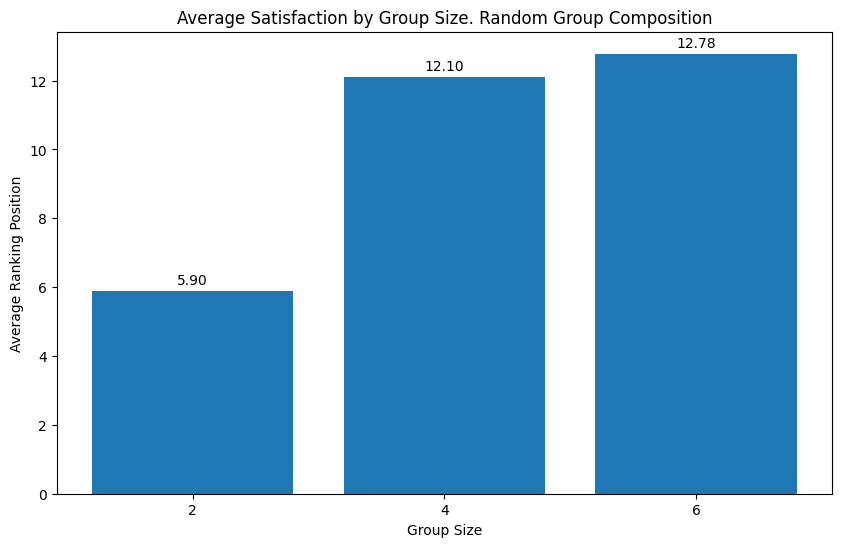

In [27]:
import matplotlib.pyplot as plt

# Sample data
group_sizes = [2, 4, 6]
average_satisfaction_random = [5.9, 12.10, 12.78]

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(group_sizes)), average_satisfaction_random, tick_label=group_sizes)
plt.xlabel("Group Size")
plt.ylabel("Average Ranking Position")
plt.title("Average Satisfaction by Group Size. Random Group Composition")
plt.xticks(range(len(group_sizes)), group_sizes)

# Add values above the bars
for bar, value in zip(bars, average_satisfaction_random):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f"{value:.2f}", ha='center', va='bottom')

plt.savefig('random.png')
plt.show()


#### Similar Group Composition

In [21]:
# average_ranking_similar = []
# group_sizes = [2, 4, 6]

# for i in range (30, 60):
#     users = group_list[i]['group_members']
#     print(users)
    
#     if group_list[i]['group_similarity'] == 'similar':
#         average_ranking_similar.append(combine_preference_of_indiv_to_make_group_recommendation(G, users))    

# print(len(average_ranking_similar))

# # Split the list into 4 groups of 10 values each
# groups = [average_ranking_similar[i:i+10] for i in range(0, len(average_ranking_similar), 10)]

# # Calculate the average of values in each group
# averages_similar = [np.mean(group) for group in groups]

# print("For random group composition: ")

# # Print the averages for each group
# for i, avg in enumerate(averages_similar):
#     print('Group size: ', group_sizes[i])
#     print(f'Average: {avg:.2f}')   

In [22]:
# import matplotlib.pyplot as plt

# # Sample data
# group_sizes = [2, 4, 6]
# average_satisfaction_similar = [4.70, 17.38, 22.60]

# # Create a bar chart
# plt.figure(figsize=(10, 6))
# bars = plt.bar(range(len(group_sizes)), average_satisfaction_similar, tick_label=group_sizes)
# plt.xlabel("Group Size")
# plt.ylabel("Average Ranking Position")
# plt.title("Average Satisfaction by Group Size. Similar Group Composition")
# plt.xticks(range(len(group_sizes)), group_sizes)

# # Add values above the bars
# for bar, value in zip(bars, average_satisfaction_similar):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f"{value:.2f}", ha='center', va='bottom')

# plt.savefig('similar.png')
# plt.show()


#### Divergent Group Composition

In [23]:
# average_ranking_divergent = []
# group_sizes = [2, 4, 6]

# for i in range (60, 90):
#     users = group_list[i]['group_members']
#     print(users)
    
#     if group_list[i]['group_similarity'] == 'divergent':
#         average_ranking_divergent.append(combine_preference_of_indiv_to_make_group_recommendation(G, users))    

# print(len(average_ranking_divergent))

# # Split the list into 4 groups of 10 values each
# groups = [average_ranking_divergent[i:i+10] for i in range(0, len(average_ranking_divergent), 10)]

# # Calculate the average of values in each group
# averages_divergent = [np.mean(group) for group in groups]

# print("For divergent group composition: ")

# # Print the averages for each group
# for i, avg in enumerate(averages_divergent):
#     print('Group size: ', group_sizes[i])
#     print(f'Average: {avg:.2f}')   

In [24]:
# import matplotlib.pyplot as plt

# # Sample data
# group_sizes = [2, 4, 6]
# average_satisfaction_divergent = [7.30, 13.40, 10.37]

# # Create a bar chart
# plt.figure(figsize=(10, 6))
# bars = plt.bar(range(len(group_sizes)), average_satisfaction_divergent, tick_label=group_sizes)
# plt.xlabel("Group Size")
# plt.ylabel("Average Ranking Position")
# plt.title("Average Satisfaction by Group Size. Givergent Group Composition")
# plt.xticks(range(len(group_sizes)), group_sizes)

# # Add values above the bars
# for bar, value in zip(bars, average_satisfaction_divergent):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f"{value:.2f}", ha='center', va='bottom')

# plt.savefig('divergent.png')
# plt.show()


In [25]:
# average_ranking_minority = []
# group_sizes = [2, 4, 6]

# for i in range (90, 120):
#     users = group_list[i]['group_members']
#     print(users)
    
#     if group_list[i]['group_similarity'] == 'similar_one_divergent':
#         average_ranking_minority.append(combine_preference_of_indiv_to_make_group_recommendation(G, users))    

# print(len(average_ranking_minority))

# # Split the list into 4 groups of 10 values each
# groups = [average_ranking_minority[i:i+10] for i in range(0, len(average_ranking_minority), 10)]

# # Calculate the average of values in each group
# averages_minority = [np.mean(group) for group in groups]

# print("For minority group composition: ")

# # Print the averages for each group
# for i, avg in enumerate(averages_minority):
#     print('Group size: ', group_sizes[i])
#     print(f'Average: {avg:.2f}')   

In [26]:
# import matplotlib.pyplot as plt

# # Sample data
# group_sizes = [2, 4, 6]
# average_ranking_minority = [5.6, 15.40, 19.18]

# # Create a bar chart
# plt.figure(figsize=(10, 6))
# bars = plt.bar(range(len(group_sizes)), average_ranking_minority, tick_label=group_sizes)
# plt.xlabel("Group Size")
# plt.ylabel("Average Ranking Position")
# plt.title("Average Satisfaction by Group Size. Minority Group Composition")
# plt.xticks(range(len(group_sizes)), group_sizes)

# # Add values above the bars
# for bar, value in zip(bars, average_ranking_minority):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f"{value:.2f}", ha='center', va='bottom')

# plt.savefig('minority.png')
# plt.show()
